
# pPXF: Fitting photometry and spectra of LEGA-C galaxies at $z\approx0.8$

![pPXF](https://www-astro.physics.ox.ac.uk/~cappellari/software/ppxf_logo.svg)

## Description

Usage example for the procedure pPXF originally described in 
[Cappellari & Emsellem (2004)](http://adsabs.harvard.edu/abs/2004PASP..116..138C),
substantially upgraded in 
[Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C) 
and with the inclusion of photometry and linear constraints in 
[Cappellari (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C).

### MODIFICATION HISTORY

* V1.0.0: Michele Cappellari, Oxford, 8 December 2023: Created
* V1.1.0: Demonstrate use of ``sps_util.mass_to_light`` and
      ``ppxf_util.mag_sun`` in pPXF v9.1. MC, Oxford, 18 January 2024
* V1.1.1: Updated for pPXF 9.2. MC, Oxford, 11 April 2024
* V1.2.0: Updated for pPXF 9.3. MC, Oxford, 28 June 2024

___

## Imports and function definitions

In [1]:
from urllib import request
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import constants, cosmology
from scipy import ndimage, stats

import ppxf.ppxf_util as util
import ppxf.sps_util as lib
from ppxf.ppxf import ppxf, robust_sigma

In [2]:
###############################################################################

def noise_spectrum(residuals, width=101, sigma=1):
    """
    Robust determination of the 1sigma error spectrum as the 68th percentile
    of the absolute residuals from a fit in a given running window.
    """
    assert width % 2 == 1, f"width = {width} must be odd"
    assert width > 10, f"width = {width} too small"

    p = 200*stats.norm.cdf(sigma) - 100  # sigma = 1 --> 68 %

    # The median residual should be nearly zero already, but I redo it anyway
    med = ndimage.median_filter(residuals, size=width)
    res = abs(residuals - med)
    noise = ndimage.percentile_filter(res, p, size=width)

    return noise/sigma  # always returns 1sigma noise spectrum

################################################################################

def clip_outliers(galaxy, noise, bestfit, mask):
    """
    Repeat the fit after clipping pixels deviating more than 3*sigma in
    relative error. Continue until there are no further changes in the bad
    bins. 
    """
    while True:
        d = galaxy[mask]/noise[mask]
        m = bestfit[mask]/noise[mask]
        scale = (d @ m)/(m @ m)   # eq. (34) Cappellari (2023)
        resid = scale*bestfit[mask] - galaxy[mask]
        err = np.zeros_like(galaxy)
        err[mask] = noise_spectrum(resid)
        mask_old = mask.copy()
        mask = np.abs(bestfit - galaxy) < 3*err  # 3sigma
        if np.array_equal(mask, mask_old):
            break

    return mask

###############################################################################

def ppxf_clip_outliers(templates, galaxy, noise, velscale, start, mask=None, phot=None, plot=False, 
                       lam=None, lam_temp=None, component=None, gas_component=None, **kwargs):
    """
    Wrapper for pPXF: 
    - Perform an initial pPXF fit;
    - Find outliers and mask pixels;
    - Rescale spectral and photometric uncertainties;
    - Perform second pPXF fit, with new mask and uncertainties.
    """
    if mask is None:
        mask = np.ones(galaxy.size, dtype=bool)

    pp = ppxf(templates, galaxy, noise, velscale, start, mask=mask, phot=phot,lam=lam, 
              lam_temp=lam_temp, component=component, gas_component=gas_component, **kwargs)

    if plot:
        plt.clf()
        plt.subplot(211)
        pp.plot()

    # Clip outliers and include clipped pixels to the previous mask
    mask &= clip_outliers(galaxy, noise, pp.bestfit, mask)

    # Scale spectrum errors to have chi2/DOF=1 after masking
    resid = ((pp.bestfit - galaxy)/noise)[mask]
    chi2 = resid @ resid
    noise *= np.sqrt(chi2/mask.sum())

    if phot is not None:
        # Scale photometry errors to have chi2/DOF=1
        phot_resid = (pp.phot_bestfit - phot["galaxy"])/phot["noise"]
        phot_chi2 = phot_resid @ phot_resid
        phot["noise"] *= np.sqrt(phot_chi2/phot["galaxy"].size)

    start = pp.sol   # start from previous pPXF solution

    # Repeat the fit after masking
    pp = ppxf(templates, galaxy, noise, velscale, start, mask=mask, phot=phot, lam=lam, 
                lam_temp=lam_temp, component=component, gas_component=gas_component, **kwargs)

    # Estimate S/N in output
    resid = (galaxy - pp.bestfit)[mask]
    rms = robust_sigma(resid, zero=1)
    flx = np.median(galaxy[mask])
    pp.sn = flx/rms

    if plot:
        plt.subplot(212)
        pp.plot()

    return pp

###############################################################################

## Read the LEGA-C spectrum
 
Selects one object, and the corresponding redshift, from the LEGA-C catalogue
by [van der Wel et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJS..256...44V/abstract).

In a real application, this will be done with a specific function reading
from the catalogue files, but I avoided including the whole catalogue for
this example. 

In [3]:
id = 56670          # ID of the UltraVISTA catalogue by Muzzin+13 (see later) -> ID = 414 in LEGA-C DR3
redshift = 0.6686   # Initial redshift estimate from the LEGA-C catalog

Read a LEGA-C galaxy spectrum taken (with permission) from the catalogue of
[van der Wel et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJS..256...44V/abstract). 
The wavelength range outside the observed limits is filled with `NaN`, which
I remove below.

In [4]:
file_dir = Path(lib.__file__).parent / 'spectra'
filename = file_dir.glob(f'legac_*_{id}_v3.0.fits')  
filename = list(filename)[0]  # get first of possible duplicates
t = fits.open(filename)[1].data
flx = np.squeeze(t['flux'])
finite = np.isfinite(flx)
galaxy_lin = flx[finite]
wave_lin = np.squeeze(t['wave'])[finite]

<font color='red'>IMPORTANT:</font> Bring the observed spectrum to the
rest-frame, using the redshift estimate provided by the LEGA-C catalogue.

In [5]:
wave_lin /= 1 + redshift

Logarithmically rebin the spectrum to a velocity scale per spectral pixel
equal to the instrumental dispersion $\sigma_{\rm inst}$ of VIMOS. This
ensures Nyquist sampling without loss of information.

In [6]:
lam_range_gal = [np.min(wave_lin), np.max(wave_lin)]
c_kms = constants.c.to('km/s').value  # speed of light in km/s
R = 3500    # LEGA-C approximate instrumental dispersion (Sec.3.2 van der Wel+21)
sigma_instr_gal = c_kms/R/2.355   # 36 km/s
galaxy, ln_lam, velscale = util.log_rebin(lam_range_gal, galaxy_lin, velscale=sigma_instr_gal)

Normalizes the galaxy spectrum to average unity. Adopt as initial estimate of
the noise a crude estimate of the true value. This choice has little effect
on the final result, as the noise will be rescaled after an initial `pPXF`
fit.

In [7]:
galaxy /= np.median(galaxy)  # Normalize spectrum to avoid numerical issues
noise = np.full_like(galaxy, 0.1)   # S=1, N=0.1 --> S/N = 10

## Setup stellar templates 

pPXF can be used with any set of SPS population templates. However, I am
currently providing (with permission) ready-to-use template files for four
SPS. One can just uncomment one of the four models below. The included files
are only a subset of the SPS that can be produced with the models, and one
should use the relevant software/website to produce different sets of SPS
templates if needed.

1. If you use the [fsps v3.2](https://github.com/cconroy20/fsps) SPS model
   templates, please also cite in your paper 
   [Conroy et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009ApJ...699..486C) and
   [Conroy et al. (2010)](https://ui.adsabs.harvard.edu/abs/2010ApJ...712..833C).

2. If you use the [GALAXEV v2020](http://www.bruzual.org/bc03/) SPS model 
   templates, please also cite in your paper 
   [Bruzual & Charlot (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.344.1000B).

3. If you use the [E-MILES](http://miles.iac.es/) SPS model templates,
   please also cite  in your paper 
   [Vazdekis et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.463.3409V).
   <font color="red">WARNING: The E-MILES models only include SPS with age > 63 Myr and
   are not recommended for highly star forming galaxies.</font>

4. If you use the [X-Shooter Spectral Library (XSL)](http://xsl.u-strasbg.fr/) 
   SPS model templates, please also cite in your paper 
   [Verro et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022A%26A...661A..50V). 
   <font color="red">WARNING: The XSL models only include SPS with age > 50 Myr and
   are not recommended for highly star forming galaxies.</font>

In [8]:
sps_name = 'fsps'
# sps_name = 'galaxev'
# sps_name = 'emiles'
# sps_name = 'xsl'

Read the SPS models file from my GitHub if not already in the pPXF package
dir. I am not distributing the templates with pPXF anymore. The SPS model
files are also available [this GitHub
page](https://github.com/micappe/ppxf_data).

In [9]:
ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

## Setup spectral templates: stars and gas

In [10]:
norm_type = 'lbol'          # Normalize spectra by their bolometric luminosity
norm_range=[0.1e4, 3e4]     # Use only observable range for bolometric integral
libs = lib.sps_lib(filename, velscale, norm_range=norm_range, norm_type=norm_type)

# The stellar templates are reshaped below into a 2-dim array with each
# spectrum as a column; however, we save the original array dimensions,
# which are needed to specify the regularization dimensions
reg_dim = libs.templates.shape[1:]
stars_templates = libs.templates.reshape(libs.templates.shape[0], -1)

# Construct a set of Gaussian emission line templates.
# The `emission_lines` function defines the most common lines, but additional
# lines can be included by editing the function in the file ppxf_util.py.
vacuum = False if sps_name == 'emiles' else True
gas_templates, gas_names, line_wave = util.emission_lines(
    libs.ln_lam_temp, lam_range_gal, FWHM_gal=0, tie_balmer=1, vacuum=vacuum)

# Combines the stellar and gaseous templates into a single array. During
# the pPXF fit they will be assigned a different kinematic COMPONENT value
templates = np.column_stack([stars_templates, gas_templates])

Emission lines included in gas templates:
['Balmer' '[NeIII]3968' '[NeIII]3869' 'HeII4687' '[OIII]5007_d']


## Input galaxy photometry

This is the most delicate part of the analysis. One has to associate the
measured photometry to the right filter names. For this example, I took the
photometric measurements and the filters associations from the [UltraVISTA
catalogue](https://local.strw.leidenuniv.nl/galaxyevolution/ULTRAVISTA/)
described in [Muzzin et al.
(2013)](https://ui.adsabs.harvard.edu/abs/2013ApJ...777...18M/abstract). The
association between the columns with flux values and the corresponding
precise filter names is generally included as a file in the catalogue, as is
the case for UltraVISTA. In a real application, these photometric
measurements are extracted automatically from a large catalogue file. But I
extracted a single line from the file, to avoid redistributing the full
catalogue.

In [11]:
bands0 = np.array(['VISTA/Ks', 'VISTA/H', 'VISTA/J', 'VISTA/Y', 
                   'IRAC/irac_tr4_2004-08-09', 'IRAC/irac_tr3_2004-08-09',
                   'IRAC/irac_tr2_2004-08-09', 'IRAC/irac_tr1_2004-08-09',
                   'COSMOS/SUBARU_filter_z', 'COSMOS/SUBARU_filter_i',
                   'COSMOS/SUBARU_filter_r', 'COSMOS/SUBARU_filter_V',
                   'COSMOS/SUBARU_filter_g', 'COSMOS/SUBARU_filter_B',
                   'megaprime/cfht_mega_u', 'Subaru_MB/IA484', 'Subaru_MB/IA527',
                   'Subaru_MB/IA624', 'Subaru_MB/IA679', 'Subaru_MB/IA738',
                   'Subaru_MB/IA768', 'Subaru_MB/IA427', 'Subaru_MB/IA464',
                   'Subaru_MB/IA505', 'Subaru_MB/IA574', 'Subaru_MB/IA709',
                   'Subaru_MB/IA827', 'CAPAK/galex1500', 'CAPAK/galex2500'])
phot_galaxy0 = np.array([256.732, 204.159, 148.225, 110.063,  57.896,  98.691, 130.98,
                         207.56,  86.484,  58.093,  21.61,   9.848,   4.404,   2.702,
                         1.189,   4.866,   8.026,  18.472,  35.406,  51.61,  63.231,
                         1.403,   2.667,   6.188,  12.902,  40.663,  71.183,   0., 0.547])
Ks_tot = 445.509
phot_galaxy0 *= Ks_tot/phot_galaxy0[0]  # Aperture flux to total one (eq.4 Muzzin+13)

The documentation by Muzzin+13 states that one should multiply the tabulated
fluxes as below, to obtain CGS units. `3631 Jy = 3.631e-20 erg/cm2/s/Hz` is
the constant flux of the AB system, but Muzzin+13 includes an extra factor
`1e-10`.

In [12]:
phot_galaxy = phot_galaxy0*3.631e-30  # erg/cm2/s/Hz  inside 2.1 arcsec aperture

## Compute photometric templates

Compute the synthetic flux of each filter-template combination at the
estimated redshift of the galaxy. 

Note that, that `synthetic_photometry` does **not** account for the $(1+z)$
dimming, due to the stretching of the spectrum. 

The output `phot_templates` array is the photometric equivalent of the
spectroscopic `templates` that are used as input to pPXF. This class also
computes the effective wavelength of each filter-template combination. If the
band falls outside of the wavelength range of the spectral templates provided
by the SPS library, the procedure returns `p1.ok=False` and prints "Outside
template" in the verbose output below.

In [13]:
p1 = util.synthetic_photometry(libs.lam_temp, templates, bands=bands0, redshift=redshift)

# Extract only the bands falling within the templates wavelength range
phot_lam, phot_lam_piv, phot_templates, phot_galaxy, bands = \
    p1.lam_eff[p1.ok], p1.lam_piv[p1.ok], p1.flux[p1.ok], phot_galaxy[p1.ok], bands0[p1.ok]

  1: VISTA/Ks
  2: VISTA/H
  3: VISTA/J
  4: VISTA/Y
  5 --- Outside template: IRAC/irac_tr4_2004-08-09
  6: IRAC/irac_tr3_2004-08-09
  7: IRAC/irac_tr2_2004-08-09
  8: IRAC/irac_tr1_2004-08-09
  9: COSMOS/SUBARU_filter_z
 10: COSMOS/SUBARU_filter_i
 11: COSMOS/SUBARU_filter_r
 12: COSMOS/SUBARU_filter_V
 13: COSMOS/SUBARU_filter_g
 14: COSMOS/SUBARU_filter_B
 15: megaprime/cfht_mega_u
 16: Subaru_MB/IA484
 17: Subaru_MB/IA527
 18: Subaru_MB/IA624
 19: Subaru_MB/IA679
 20: Subaru_MB/IA738
 21: Subaru_MB/IA768
 22: Subaru_MB/IA427
 23: Subaru_MB/IA464
 24: Subaru_MB/IA505
 25: Subaru_MB/IA574
 26: Subaru_MB/IA709
 27: Subaru_MB/IA827
 28: CAPAK/galex1500
 29: CAPAK/galex2500


## Convert observed photometry to flux/A

I convert exactly the observed galaxy values from `flux/Hz` into `flux/A`
using the pivot wavelength $\lambda_{\rm piv}$ of each filter (eq. 16 of
[Cappellari 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C)). 

NB: `synthetic_photometry` computes $\lambda_{\rm piv}$ in the restframe
wavelength and I must shift it to the observed redshift as $\lambda^{\rm
obs}_{\rm piv}=\lambda^{\rm rest}_{\rm piv}(1+z)$ below.

In [14]:
phot_lam_piv *= 1 + redshift                # Use observed wavelength in flux conversion
c_as = constants.c.to('Angstrom/s').value   # speed of light in A/s
phot_galaxy *= c_as/phot_lam_piv**2         # Exact conversion flux/Hz --> flux/A

## Scale photometry to match galaxy spectrum

The photometry was not measured in the same aperture as the spectra.
Moreover, the *relative* calibration of spectra and photometry is never
sufficiently accurate. For this reason, I scale the photometry to match the
spectrum flux, and save the scaling factor for later. 

For this, I compute the synthetic photometry on the LEGA-C spectrum, for the
few filters that fall within the spectrum wavelength range, and match the
synthetic predictions to the observed photometry from Muzzin+13. (see Sec.
6.4 of [Cappellari 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C)). 

The procedure `synthetic_photometry` checks if a filters fall within the
wavelength range of the spectrum and returns `p2.ok=False`, and prints
"Outside template" in the verbose output, for filters where this is not the
case.

In [15]:
# Compute synthetic photometry on LEGA-C galaxy spectrum, which is already in rest-frame
p2 = util.synthetic_photometry(np.exp(ln_lam), galaxy, bands=bands, redshift=redshift)

# Extract the bands that fall inside the galaxy spectrum
# Scale photometry to match the synthetic one from the LEGA-C spectrum
err = 1                     # Assume constant uncertainties
d = p2.flux[p2.ok]/err      # photometry predicted from spectrum
m = phot_galaxy[p2.ok]/err  # photometry observed
scale = (d @ m)/(m @ m)     # eq. (34) Cappellari (2023)
phot_galaxy *= scale        # Match photometry to spectrum

  1 --- Outside template: VISTA/Ks
  2 --- Outside template: VISTA/H
  3 --- Outside template: VISTA/J
  4 --- Outside template: VISTA/Y
  5 --- Outside template: IRAC/irac_tr3_2004-08-09
  6 --- Outside template: IRAC/irac_tr2_2004-08-09
  7 --- Outside template: IRAC/irac_tr1_2004-08-09
  8 --- Outside template: COSMOS/SUBARU_filter_z
  9: COSMOS/SUBARU_filter_i
 10 --- Outside template: COSMOS/SUBARU_filter_r
 11 --- Outside template: COSMOS/SUBARU_filter_V
 12 --- Outside template: COSMOS/SUBARU_filter_g
 13 --- Outside template: COSMOS/SUBARU_filter_B
 14 --- Outside template: megaprime/cfht_mega_u
 15 --- Outside template: Subaru_MB/IA484
 16 --- Outside template: Subaru_MB/IA527
 17 --- Outside template: Subaru_MB/IA624
 18: Subaru_MB/IA679
 19: Subaru_MB/IA738
 20: Subaru_MB/IA768
 21 --- Outside template: Subaru_MB/IA427
 22 --- Outside template: Subaru_MB/IA464
 23 --- Outside template: Subaru_MB/IA505
 24 --- Outside template: Subaru_MB/IA574
 25: Subaru_MB/IA709
 26: Subaru

## pPXF input parameters

Create the input `phot` dictionary for `pPXF`.
I assign an initial uncertainties of 3% of the maximum flux. This choice has
little influence on the final result, as the uncertainties will be rescaled
after an initial `pPXF` fit.

In [16]:
phot_noise = np.full_like(phot_galaxy, np.max(phot_galaxy)*0.03)   # assume 1sigma uncertainties of 3%
phot = {"templates": phot_templates, "galaxy": phot_galaxy, "noise": phot_noise, "lam": phot_lam}

I adopt two kinematic components, one for the stars ``component=0`` and one
for the gas ``component=1``. For each component I fit two moments $(V, \sigma)$. 
I start the fit from a feasible guess and place reasonable bounds on the
parameters.

When studying stellar population, one should not use additive polynomials, to
avoid changing the line strength of the  spectra. Instead, I use
multiplicative polynomials of ``mdegree=2`` (see Sec. 6.2 of 
[Cappellari 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C)).

In [17]:
start_stars = [0, 200.]     # (km/s), starting guess for [V, sigma]
start_gas = [1, 100.]       # ensures feasible start: sigma_gas < sigma_stars
start = [start_stars, start_gas]

bounds = [[[-500, 500], [1, 500]],   # Important: sigma lower bound cannot be zero
          [[-500, 500], [1, 500]]]

n_stars = stars_templates.shape[1]
n_gas = len(gas_names)

# I fit two kinematics components, one for the stars and one for the gas.
# Assign component=0 to the stellar templates, component=1 to the gas.
component = [0]*n_stars + [1]*n_gas    
gas_component = np.array(component) > 0  # gas_component=True for gas templates

# Fit (V, sig) moments=2 for both the stars and the gas
moments = [2, 2]

mdegree = 2   # Adopt a degree=2 multiplicative polynomial

In my initial tests, I noticed that in some galaxies without gas, pPXF
introduces an extremely broad spurious gas emission, which is essentially
acting like an additive polynomial rather than a genuine emission line. I use
linear constraints to prevent this from happening. 

Given that I am not interested in the gas kinematics, I set the constraint
that the gas velocity $\sigma_{\rm gas}$ dispersion (`component=1`) must be
smaller than the stellar velocity dispersion $\sigma_*$ (`component=0`). This
is not always true, but appears to work well in this case.

In formulas, I want to have:

$$\sigma_{\rm gas} < \sigma_*$$

Following standard practice in numerical optimization (e.g.
[HERE](https://uk.mathworks.com/help/optim/ug/linear-constraints.html)), I
express this inequality as a linear constraint as this leads to an efficient
optimization algorithm, with guaranteed local convergence:

$$\mathbf{A}_{\rm ineq}\cdot \mathbf{p} < \mathbf{b}_{\rm ineq}.$$

In this example, the vector of nonlinear kinematic parameters is
$\mathbf{p}=[V_0, \sigma_0, V_1, \sigma_1]$ (following the same order of the
`start` parameters of `pPXF`) and I can write the above matrix equation
explicitly as (in this case the matrix $\mathbf{A}_{\rm ineq}$ has a single
row)

$$
\begin{bmatrix}
0 & -1 & 0 & 1 \\
\end{bmatrix}
\cdot
\begin{bmatrix}
V_0 \\
\sigma_0 \\
V_1 \\
\sigma_1
\end{bmatrix}
<
\begin{bmatrix}
0\\
\end{bmatrix}.
$$

This translates into the following Python code

In [18]:
# Constrain the gas dispersion to be smaller than the stellar one
A_ineq = [[0, -1, 0, 1]]       # -sigma1 + sigma2 < 0
b_ineq = [0]
constr_kinem = {"A_ineq": A_ineq, "b_ineq": b_ineq}

Finally I specify the attenuation. I use two different attenuation curves for
the stars and the gas:
- For the stars I use a two-parameter attenuation, parametrized by the
  $V$-band attenuation $A_V$ and the slope $\delta$ (eq. 23 of [Cappellari
  2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C)).
- For the gas I adopt a single-parameter [Calzetti et al.
  (2000)](https://ui.adsabs.harvard.edu/abs/2000ApJ...533..682C) curve.

In [19]:
dust = [{"start": [0.11, -0.2], "bounds": [[0, 4], [-1, 0.4]], "component": ~gas_component},
        {"start": [0.12], "bounds": [[0, 8]], "component": gas_component}]

## pPXF fit with iterative clipping

Adopt a regularization parameter and start the pPXF fit, including
iteratively clipping of outliers.

In [20]:
regul = 10  # A fixed `regul` can be used because galaxy and templates are normalized
pp = ppxf_clip_outliers(templates, galaxy, noise, velscale, start,
    moments=moments, degree=-1, mdegree=mdegree, lam=np.exp(ln_lam), lam_temp=libs.lam_temp, 
    regul=regul, reg_dim=reg_dim, component=component, dust=dust, gas_component=gas_component,
    gas_names=gas_names, phot=phot, plot=0, constr_kinem=constr_kinem, bounds=bounds)

 Best Fit:       Vel     sigma
 comp.  0:       -39       218
 comp.  1:       -79        41
Attenuation Parameters 0: 0.000 0.393
Attenuation Parameters 1: 7.974
chi2/DOF: 0.1054; DOF: 2727; degree = -1; mdegree = 2
Photometry chi2/n_bands: 0.4353; n_bands: 28
method = capfit; Jac calls: 6; Func calls: 62; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/392
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                Balmer    0.01714      0.27     -79    41
Comp:  1           [NeIII]3968    0.07280      0.20     -79    41
Comp:  1           [NeIII]3869      0.000      0.20     -79    41
Comp:  1              HeII4687      0.000      0.20     -79    41
Comp:  1          [OIII]5007_d     0.5211      0.26     -79    41
-----------------------------------------------------------------
 Best Fit:       Vel     sigm

## Population, stellar mass and redshift

Extract the weights for the stars only (no gas) and compute the
luminosity-weighted age and metallicity.

In [21]:
light_weights = pp.weights[~gas_component]      # Exclude weights of the gas templates
light_weights = light_weights.reshape(reg_dim)  # Reshape to (n_ages, n_metal)

# Given that the templates are normalized to L_bol, the pPXF weights represent
# L_bol light fractions and the computed ages and metallicities below are also
# light weighted by L_bol.
libs.mean_age_metal(light_weights);

Weighted <lg_age> [yr]: 9.53
Weighted <[M/H]>: 0.166


### Stellar mass using all bands (recommended)

This is the recommended approach, using all bands for the overall normalization.

- Convert the light weights into mass weights, using the ``libs.flux``
  attribute;
- Multiply by the mass fraction ``libs.mass_no_gas_grid`` in stars and
  remnants (i.e. excluding gas loss);
- Multiply by the area of a sphere of radius $D_L$ to convert observed fluxes
  into intrinsic luminosity;
- Multipy by $(1+z)$ to correct for the decrease with redshift of the
  spectrum flux density in $\mathrm{cgs/\AA}$;
- Divide by $L_\odot$ to convert fluxes to Solar luminosities;
- Divide by the ``scale`` to undo the scaling previously applied to match the
  photometry to the the spectrum.

In [22]:
cosmo = cosmology.FlatLambdaCDM(H0=70, Om0=0.3)     # Adopt standard flat cosmology
lum_dist = cosmo.luminosity_distance(redshift).to('cm').value  # in cm as fluxes are erg/s/cm^2/A
area_sphere = 4*np.pi*lum_dist**2                   # Convert observed flux/cm^2 to luminosity
dist_fact = area_sphere*(1 + redshift)              # Correct for flux/A ~ 1/(1 + z)
Lsun = constants.L_sun.to('erg/s').value            # erg/s (IAU definition) - Spectra are in units of Lsun/A
mass_weights = light_weights/libs.flux              # Convert from light weights to mass weights
lg_mpop = np.log10((libs.mass_no_gas_grid*mass_weights).sum()*dist_fact/Lsun/scale)  # This is survived stellar mass
print(f"Total stellar mass: lg(M*/Msun) = {lg_mpop:.2f}")

Total stellar mass: lg(M*/Msun) = 11.64


### Alternative stellar mass using a single band and $(M_*/L)_{\rm pop}$

This approach is useful if one has the luminosity in a single band and the
population comes from spectrum fitting. I give it here for illustration and
cross check.

The stellar mass can be obtained using a single band for normalization as
follows:

- Convert the galaxy flux into apparent $x$-band AB magnitudes $m_x = 25 -2.5
  \lg(f_x)$ following [Muzzin et al.
  (2013)](https://ui.adsabs.harvard.edu/abs/2013ApJ...777...18M/abstract);
- Convert the apparent into absolute magnitude $M_x$ ($d=10$ pc);
- Also correct as $1/(1+z)$ for the increase with redshift of the spectrum
  flux density in $\mathrm{cgs/Hz}$;
- Compute the absolute magnitude of the Sun $M_{\odot x}$ in the redshifted
  $x$ band;
- Convert the galaxy $M_x$ absolute magnitudes into $L_x$ solar luminosities.
  Up to here the process is general and does not depend on SED fitting;
- Now compute the galaxy stellar $(M_*/L_x)_{\rm pop}$ from the ``pPXF``
  weights;
- Finally convert the galaxy luminosity into total stellar mass
  $M_*=L_x\times(M_*/L_x)_{\rm pop}$.

This method yields similar but not identical stellar masses when using
different $x$-bands, as one can verify by uncommenting different bands below.

In [23]:
# band_x = 'VISTA/Ks'
band_x = 'COSMOS/SUBARU_filter_z'
# band_x = 'megaprime/cfht_mega_u'
# band_x = 'CAPAK/galex2500'
w = bands0 == band_x
mag_x = 25 - 2.5*np.log10(phot_galaxy0[w])  # AB mag
dist_ratio = cosmo.luminosity_distance(redshift).to('pc').value/10
abs_mag_x = mag_x - 2.5*np.log10(dist_ratio**2/(1 + redshift))  # Correct for flux/Hz ~ (1 + z)
abs_mag_x_sun = util.mag_sun(band_x, redshift=redshift)
lum_x = 10**(0.4*(abs_mag_x_sun - abs_mag_x))
ml = libs.mass_to_light(light_weights, band=band_x, redshift=redshift)
lg_mpop = np.log10(lum_x*ml).item()
print(f"Total stellar mass: lg(M*/Msun) = {lg_mpop:.2f}")

(M*/L)=3.540 (COSMOS/SUBARU_filter_z at z=0.6686)
Total stellar mass: lg(M*/Msun) = 11.64


### Redshift

Compute the redshift and its uncertainty (eq. 5 of 
[Cappellari 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C)).

In [24]:
errors = pp.error[0]*np.sqrt(pp.chi2)               # Assume the fit is good: make chi2/DOF=1
vpec = pp.sol[0][0]                                 # Stellar velocity is 1st element of 1st kinematics component
vcosm = c_kms*np.log(1 + redshift)                  # eq. 5a of Cappellari (2023)
vtot = vcosm + vpec                                 # eq. 5b 
redshift_ppxf = np.exp(vtot/c_kms) - 1              # eq. 5c
redshift_err = (redshift_ppxf + 1)*errors[0]/c_kms  # eq. 5d

prec = int(1 - np.floor(np.log10(redshift_err)))    # two digits of uncertainty
print(f"Best-fitting redshift: z = {redshift_ppxf:#.{prec}f} +/- {redshift_err:#.{prec}f}")

Best-fitting redshift: z = 0.668380 +/- 0.000016


## Plotting

Plot results: photometry and spectroscopy fit, and luminous weight
distribution (like Figs. 5 and 6 of 
[Cappellari 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C)).

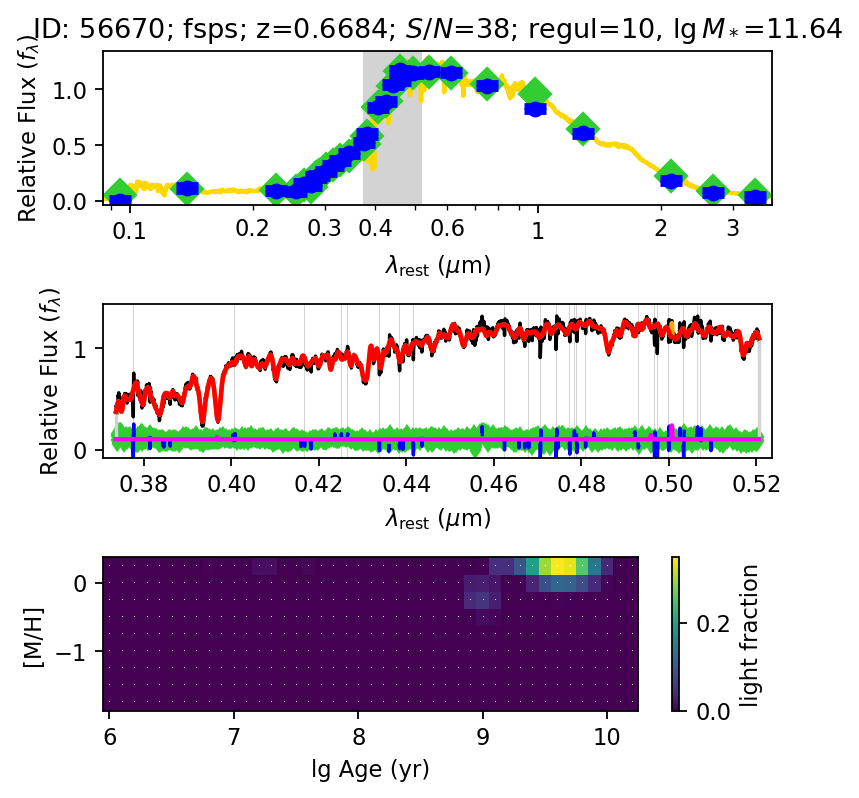

In [25]:
# Plot fit results for stars and gas.
plt.figure(figsize=(5, 5))

# Plot photometry fit
plt.subplot(311)
pp.plot(gas_clip=1, spec=0, lam_flam=False)
plt.title(f"ID: {id}; {sps_name}; z={redshift_ppxf:.4f}; $S/N$={pp.sn:.0f}; regul={regul}, $\\lg M_*$={lg_mpop:.2f}")

# Plot spectrum fit
plt.subplot(312)
pp.plot(gas_clip=1, phot=0, lam_flam=False)

# Plot stellar population light-fraction distribution
plt.subplot(313)
libs.plot(light_weights, title="", colorbar_label="light fraction")
plt.tight_layout()
plt.pause(5)